In [39]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from collections import defaultdict
import folium
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from library import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import CBRE data

cbre_metro = 'Seattle'
cbre = import_cbre(metro = cbre_metro)

# Import Zillow data. 

# Zip Codes in Zillow metro area

# zillow_metro = 'Seattle-Tacoma-Bellevue'
# zillow = import_zillow(metro = zillow_metro)

# Or Zip Codes in CBRE

zillow = import_zillow(zip_code=cbre.index)

In [3]:
# Check number of states

zillow.State.unique()

array(['WA'], dtype=object)

In [4]:
# Import centroid data and geo data. Set the center coordinates of the map.

zip_centroid = import_centroid()
geojson = f'../data/wa_washington_zip_codes_geo.min.json'
coor = [47.6062, -122.3321]

In [5]:
# Import population data.

zip_pop = import_pop()

### CBRE Map

In [6]:
# Get statistics of CBRE submarkets.

get_stat(cbre,zip_pop)

,submktname,Population,Household_Count
520 Corridor,4,26417.5,13782.0
Ballard / U Dist,9,21147.0,12360.0
Bellevue CBD,4,22830.0,12319.0
Bothell / Kenmore,9,24517.0,9793.5
Coal Creek / Issaquah,14,24379.5,9247.0
Denny Regrade,1,12628.0,10149.0
E King County,7,35175.0,12792.5
Edmonds / Lynnwood,10,28432.5,11451.0
Everett CBD,5,29582.0,13899.0
Federal Way / Auburn,13,31911.0,13480.0


In [7]:
# Calculate centroids of CBRE submarkets.

cbre_centroid = get_centroid(cbre,zip_centroid)

In [8]:
# Make a map for CBRE submarkets.

cbre_le = preprocessing.LabelEncoder()
cbre_le.fit(cbre.submkt_id)

cbre['submkt_id_label'] = cbre_le.transform(cbre.submkt_id)
cbre_map = make_map(geojson,coor,cbre.submkt_id.nunique(),
                    cbre['submkt_id_label'].reset_index(),centroid=cbre_centroid)

cbre_map.save('../fig/'+cbre_metro+'_cbre.html')

### Zillow Clustering

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

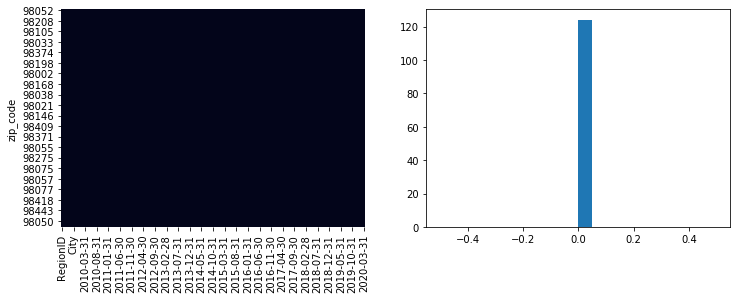

In [9]:
# Check missingness in Zillow data.

plot_missing(zillow)

In [10]:
# Impute

zillow = zillow.dropna()

In [11]:
# Split the information part and time series part in Zillow data.

zillow_info,zillow_ts = split_zillow(zillow)

# Calculate the percentage change of time series data.

change = get_change(zillow_ts)

In [12]:
# Incorporate centroid information into time series data to make 'synthetic' data. 
# Control the relative value of centroid data by adjusting its 'weight'. 
# When weight = 0, 'syn' is equivalent to time series information only.

weight = 5
syn = get_syn(change,zip_centroid,weight)

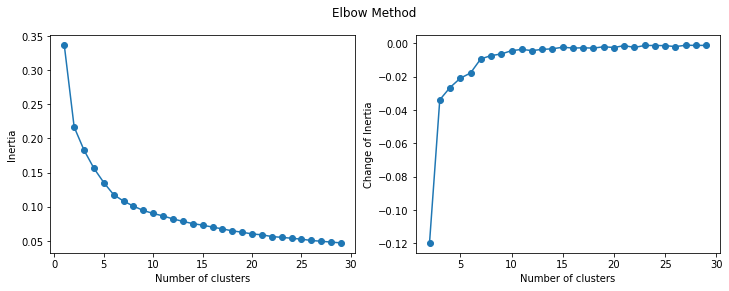

In [13]:
# Use elbow method to find the optimum number of clusters.

kmeans = KMeans(n_init=40, random_state=42)

plot_inertia(kmeans, syn, range(1, 30))

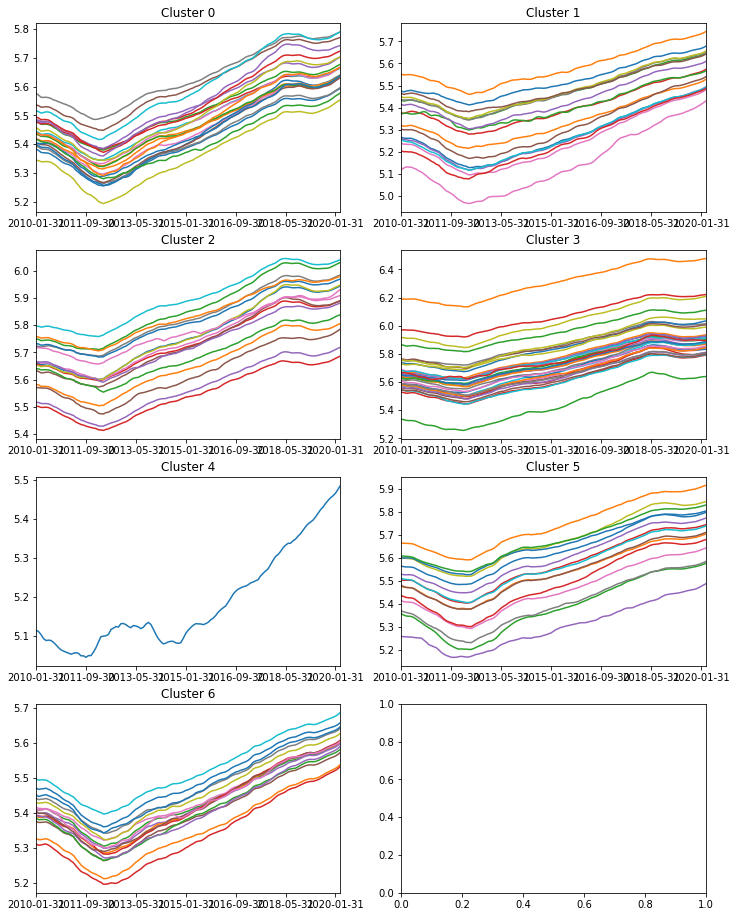

In [14]:
# Set the number of clusters. Run k-means clustering. 
# Plot out time series curves for each cluster, in logarithmic scale.

ncluster = 7
km_predict = fit_kmeans(ncluster, syn, kmeans)
plot_clusters(km_predict,zillow_ts)

In [15]:
# Make map of submarkets.

geo_map = make_map(geojson,coor,ncluster,km_predict)
# geo_map
geo_map.save('../fig/'+cbre_metro+'_km_'+str(ncluster)+'.html')

In [16]:
# Get statistics of submarkets.

get_stat(km_predict,zip_pop)

,submktname,Population,Household_Count
0,23,31911,12541.0
1,17,19885,9427.0
2,17,22312,8942.0
3,34,21694,12160.5
4,1,1308,27.0
5,15,29779,13077.0
6,17,20468,8867.0


In [17]:
# Add a column 'submktname' in 'zillow_info'. Name submarkets with 'Layer0 + number'. Layer0 means top layer.

zillow_info['submktname'] = km_predict.set_index('zip_code')['submktname'].map(lambda x: 'Layer0 - '+str(x))

Repeat the clustering precedure for each submarket that needs to be further divided.

### Cluster 0

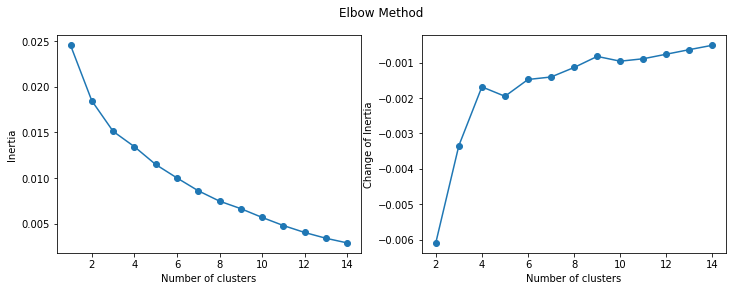

In [18]:
cluster = 0 # Name of the cluster

sub_ts = zillow_ts[zillow_ts.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]
sub_change = change[change.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]

weight = 6
sub_syn = get_syn(sub_change,zip_centroid,weight)

kmeans = KMeans(n_init=40, random_state=42)

plot_inertia(kmeans, sub_syn, range(1, 15))

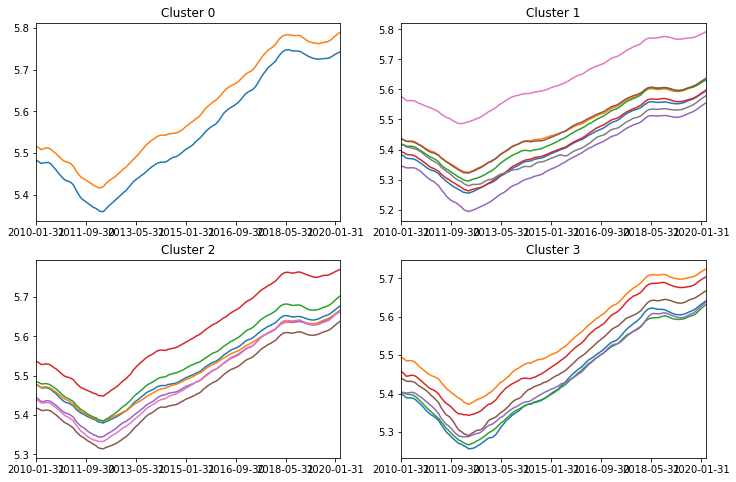

In [19]:
ncluster = 4
sub_km_predict = fit_kmeans(ncluster, sub_syn, kmeans)
plot_clusters(sub_km_predict,sub_ts)

In [20]:
geo_map = make_map(geojson,coor,ncluster,sub_km_predict)
# geo_map

In [21]:
# Append 'Layer1 + number' to submarket names.

sub_submktname = sub_km_predict.set_index('zip_code')['submktname'].map(lambda x: 'Layer1 - '+str(x))
zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'] = \
       zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'].str.cat(sub_submktname,sep='/')

### Cluster 2

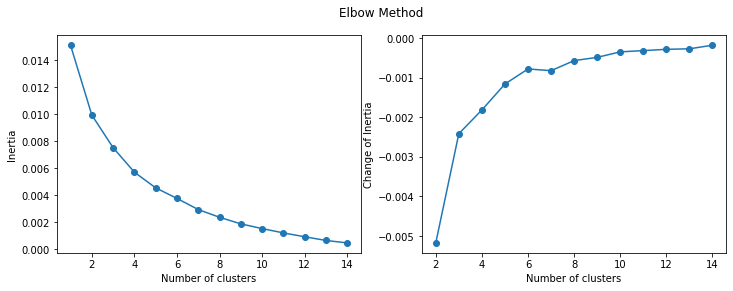

In [22]:
cluster = 2 # Name of the cluster

sub_ts = zillow_ts[zillow_ts.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]
sub_change = change[change.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]

weight = 6
sub_syn = get_syn(sub_change,zip_centroid,weight)

kmeans = KMeans(n_init=40, random_state=42)

plot_inertia(kmeans, sub_syn, range(1, 15))

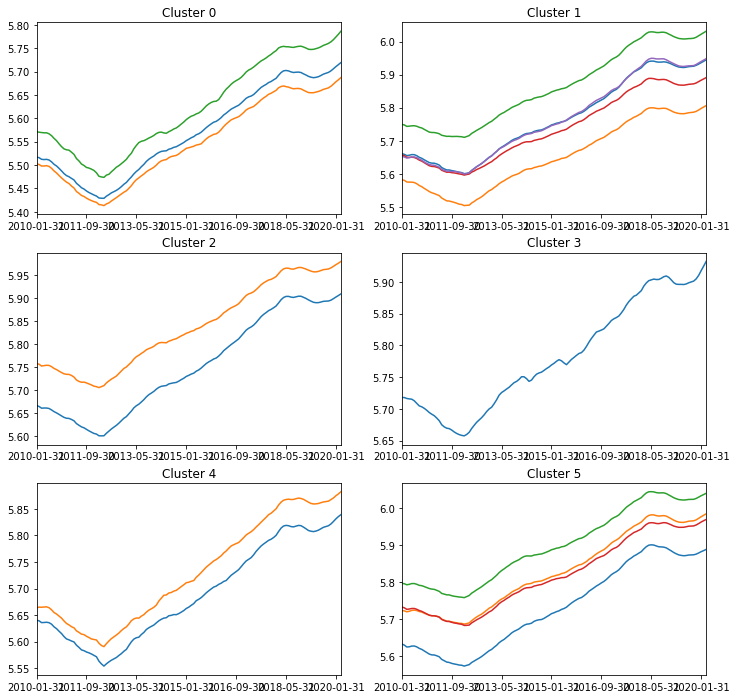

In [23]:
ncluster = 6
sub_km_predict = fit_kmeans(ncluster, sub_syn, kmeans)
plot_clusters(sub_km_predict,sub_ts)

In [24]:
geo_map = make_map(geojson,coor,ncluster,sub_km_predict)
# geo_map

In [25]:
sub_submktname = sub_km_predict.set_index('zip_code')['submktname'].map(lambda x: 'Layer1 - '+str(x))
zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'] = \
       zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'].str.cat(sub_submktname,sep='/')

### Cluster 3

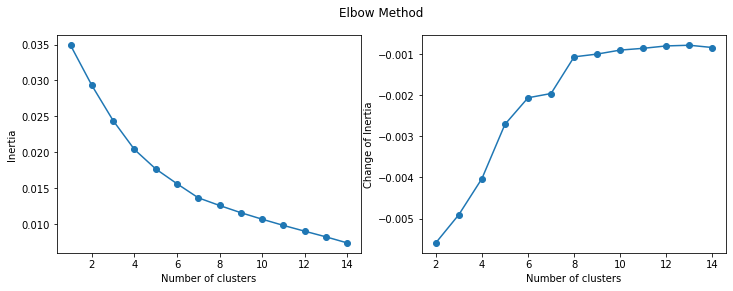

In [26]:
cluster = 3 # Name of the cluster

sub_ts = zillow_ts[zillow_ts.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]
sub_change = change[change.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]

weight = 4
sub_syn = get_syn(sub_change,zip_centroid,weight)

kmeans = KMeans(n_init=40, random_state=42)

plot_inertia(kmeans, sub_syn, range(1, 15))

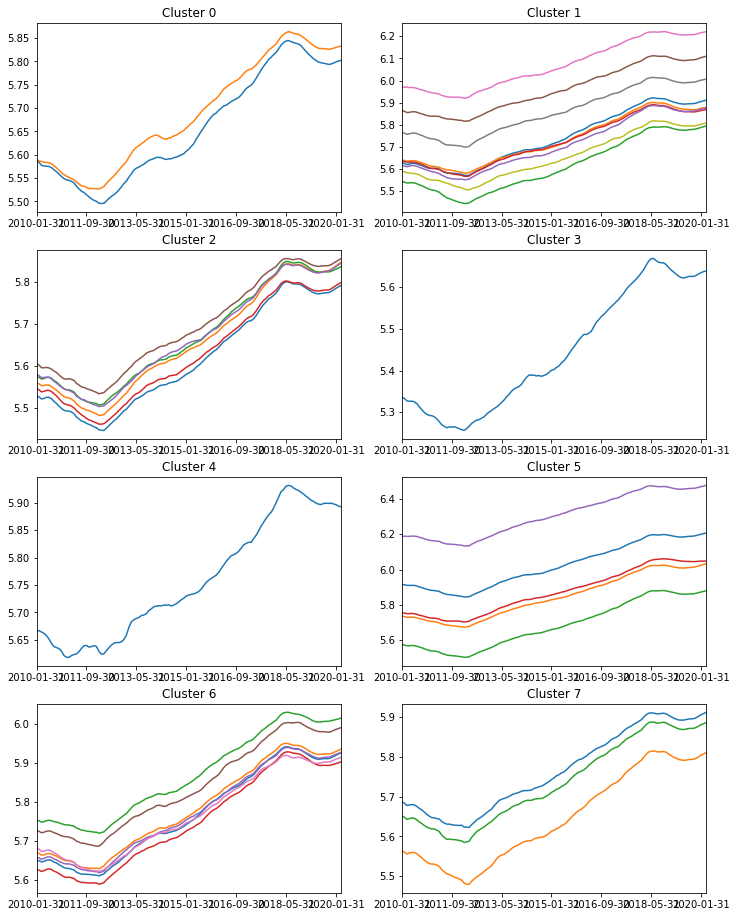

In [27]:
ncluster = 8
sub_km_predict = fit_kmeans(ncluster, sub_syn, kmeans)
plot_clusters(sub_km_predict,sub_ts)

In [28]:
geo_map = make_map(geojson,coor,ncluster,sub_km_predict)
# geo_map

In [29]:
sub_submktname = sub_km_predict.set_index('zip_code')['submktname'].map(lambda x: 'Layer1 - '+str(x))
zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'] = \
       zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'].str.cat(sub_submktname,sep='/')

### Cluster 5

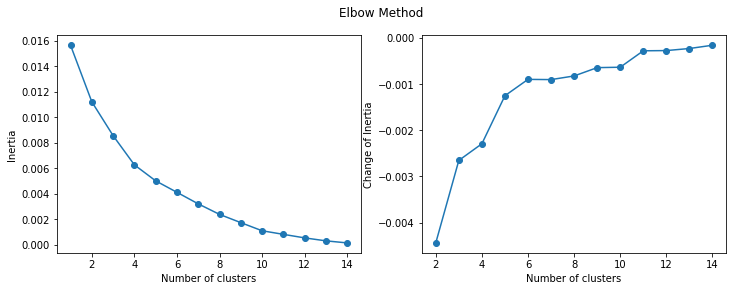

In [30]:
cluster = 5 # Name of the cluster

sub_ts = zillow_ts[zillow_ts.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]
sub_change = change[change.index.isin(km_predict.loc[km_predict['submktname'] == cluster,
                                              'zip_code'])]

weight = 6
sub_syn = get_syn(sub_change,zip_centroid,weight)

kmeans = KMeans(n_init=40, random_state=42)

plot_inertia(kmeans, sub_syn, range(1, 15))

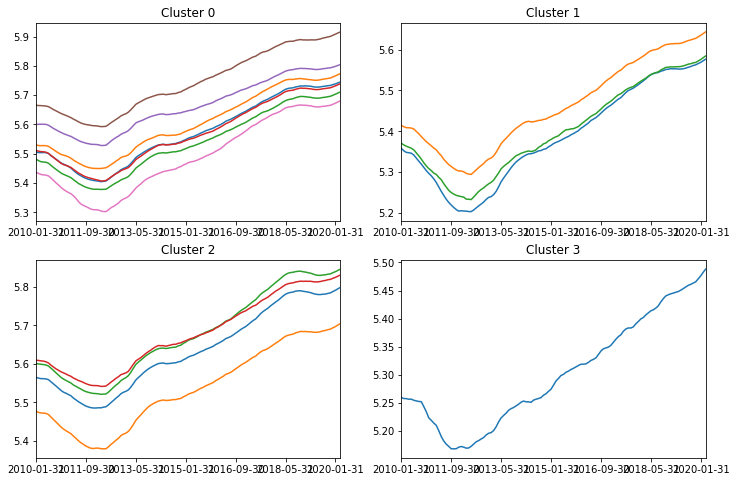

In [31]:
ncluster = 4
sub_km_predict = fit_kmeans(ncluster, sub_syn, kmeans)
plot_clusters(sub_km_predict,sub_ts)

In [32]:
geo_map = make_map(geojson,coor,ncluster,sub_km_predict)
# geo_map

In [33]:
sub_submktname = sub_km_predict.set_index('zip_code')['submktname'].map(lambda x: 'Layer1 - '+str(x))
zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'] = \
       zillow_info.loc[zillow_info.index.isin(sub_submktname.index),'submktname'].str.cat(sub_submktname,sep='/')

### Plot Submarkets

Make map of submarkets with labels.

In [34]:
zillow_centroid = get_centroid(zillow_info,zip_centroid)

In [35]:
zillow_le = preprocessing.LabelEncoder()
zillow_le.fit(zillow_info.submktname)

LabelEncoder()

In [36]:
zillow_info['submktname_label'] = zillow_le.transform(zillow_info.submktname)
zillow_map = make_map(geojson,coor,zillow_info.submktname_label.nunique(),
                    zillow_info.submktname_label.reset_index(),centroid=zillow_centroid)

In [37]:
zillow_map.save('../fig/'+cbre_metro+'.html')

### Plot Time Series Curves For Each Cluster

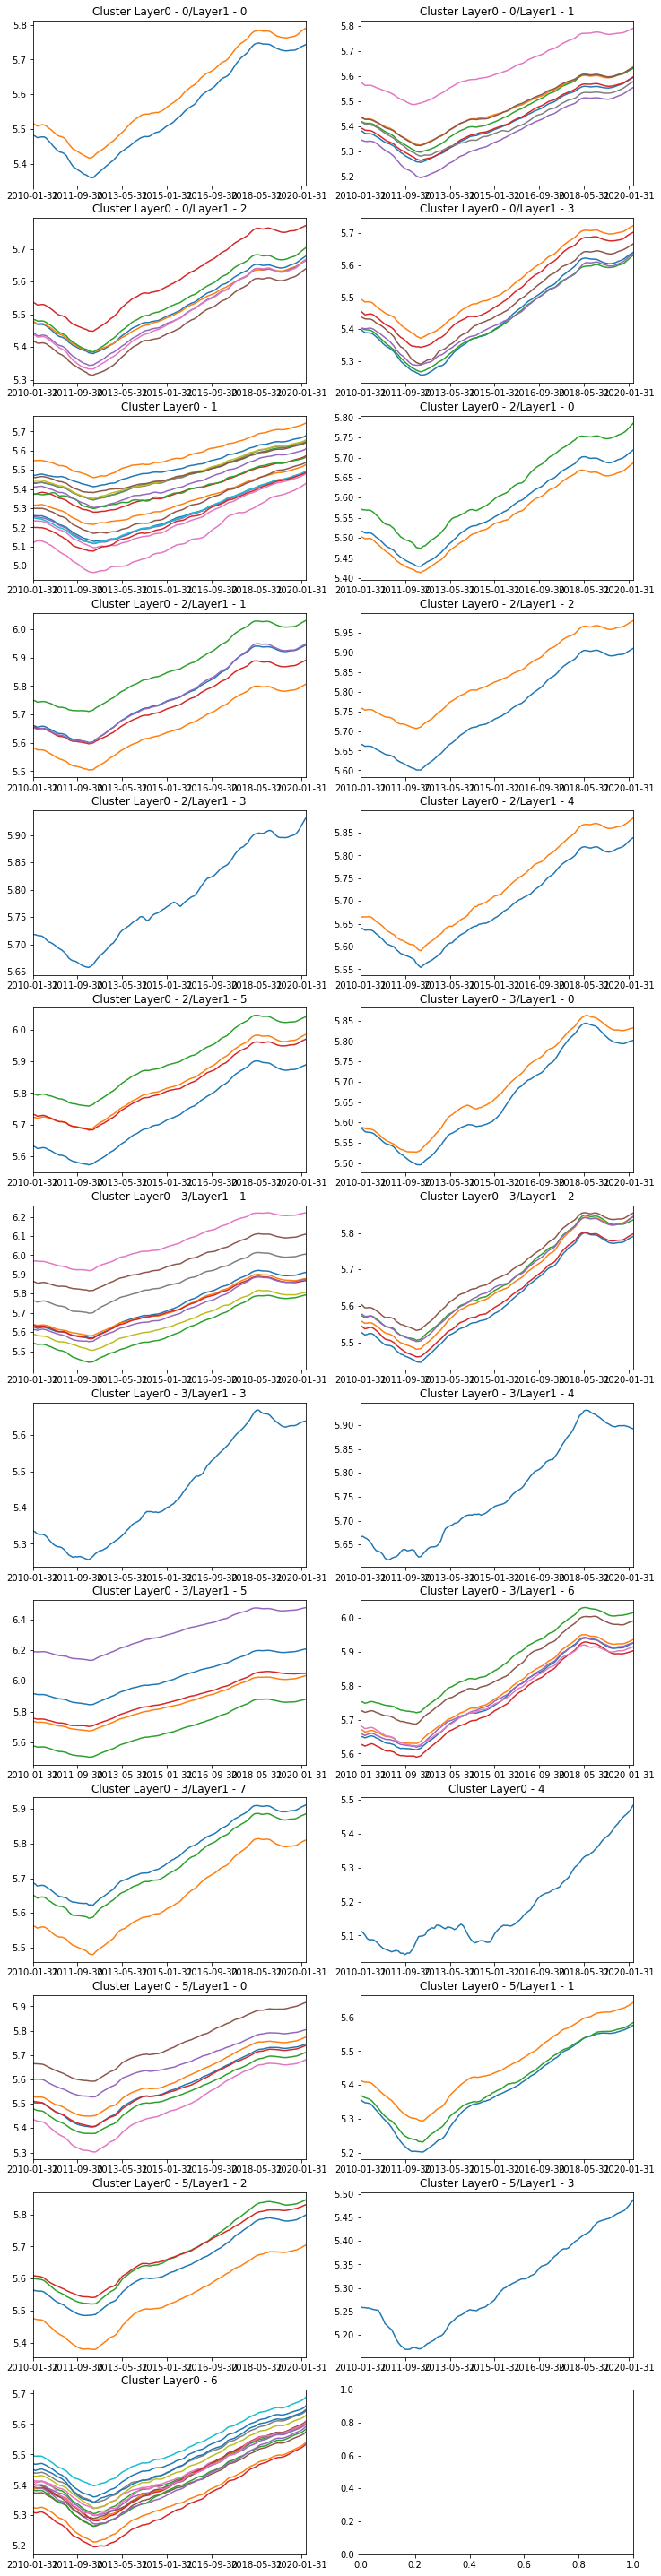

In [38]:
plot_clusters(zillow_info.reset_index()[['zip_code','submktname']],zillow_ts,log=True)